In [55]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)


In [2]:
import pandas as pd
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from IPython.display import Image
import collections
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_score, recall_score, roc_auc_score 
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
df = pd.read_csv('Suicide_Detection.csv')

In [4]:
df.shape

(232074, 3)

Exploring data

In [5]:
df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [6]:
df.isnull().any()

Unnamed: 0    False
text          False
class         False
dtype: bool

In [7]:
# drop rows with null values
df = df.dropna()

In [8]:
df.shape

(232074, 3)

In [9]:
print(df.groupby(['class'])['class'].count())

class
non-suicide    116037
suicide        116037
Name: class, dtype: int64


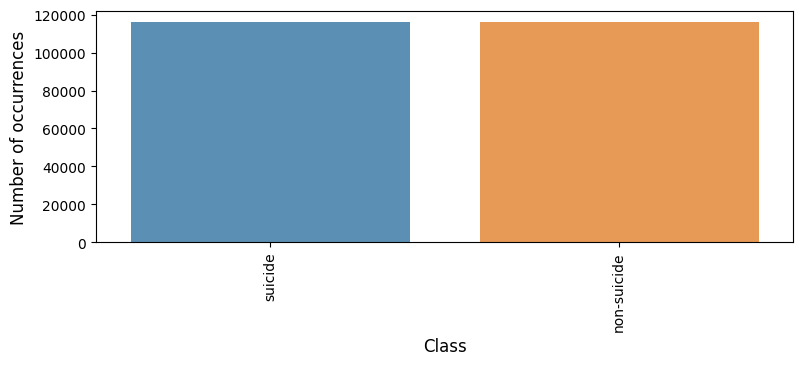

In [10]:
topic = df['class'].value_counts()
plt.figure(figsize=(9,3))
sns.barplot(x=topic.index, y=topic.values, alpha=0.8)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Checking the number of existing words in the data set

In [11]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

30528508

We have over 30 million words, this is a relatively large dataset

In [12]:
# Creating auxiliary variables for data exploration

df['post_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

**Viewing the text length and word count distribution of Posts**

In [13]:
# copy dataframe for analyze
post_users_analyze = df.copy()
# get list of labels
list_labels = post_users_analyze['class'].unique()

In [14]:
# Creating auxiliary variables for data exploration

post_users_analyze['post_len'] = df['text'].astype(str).apply(len)
post_users_analyze['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

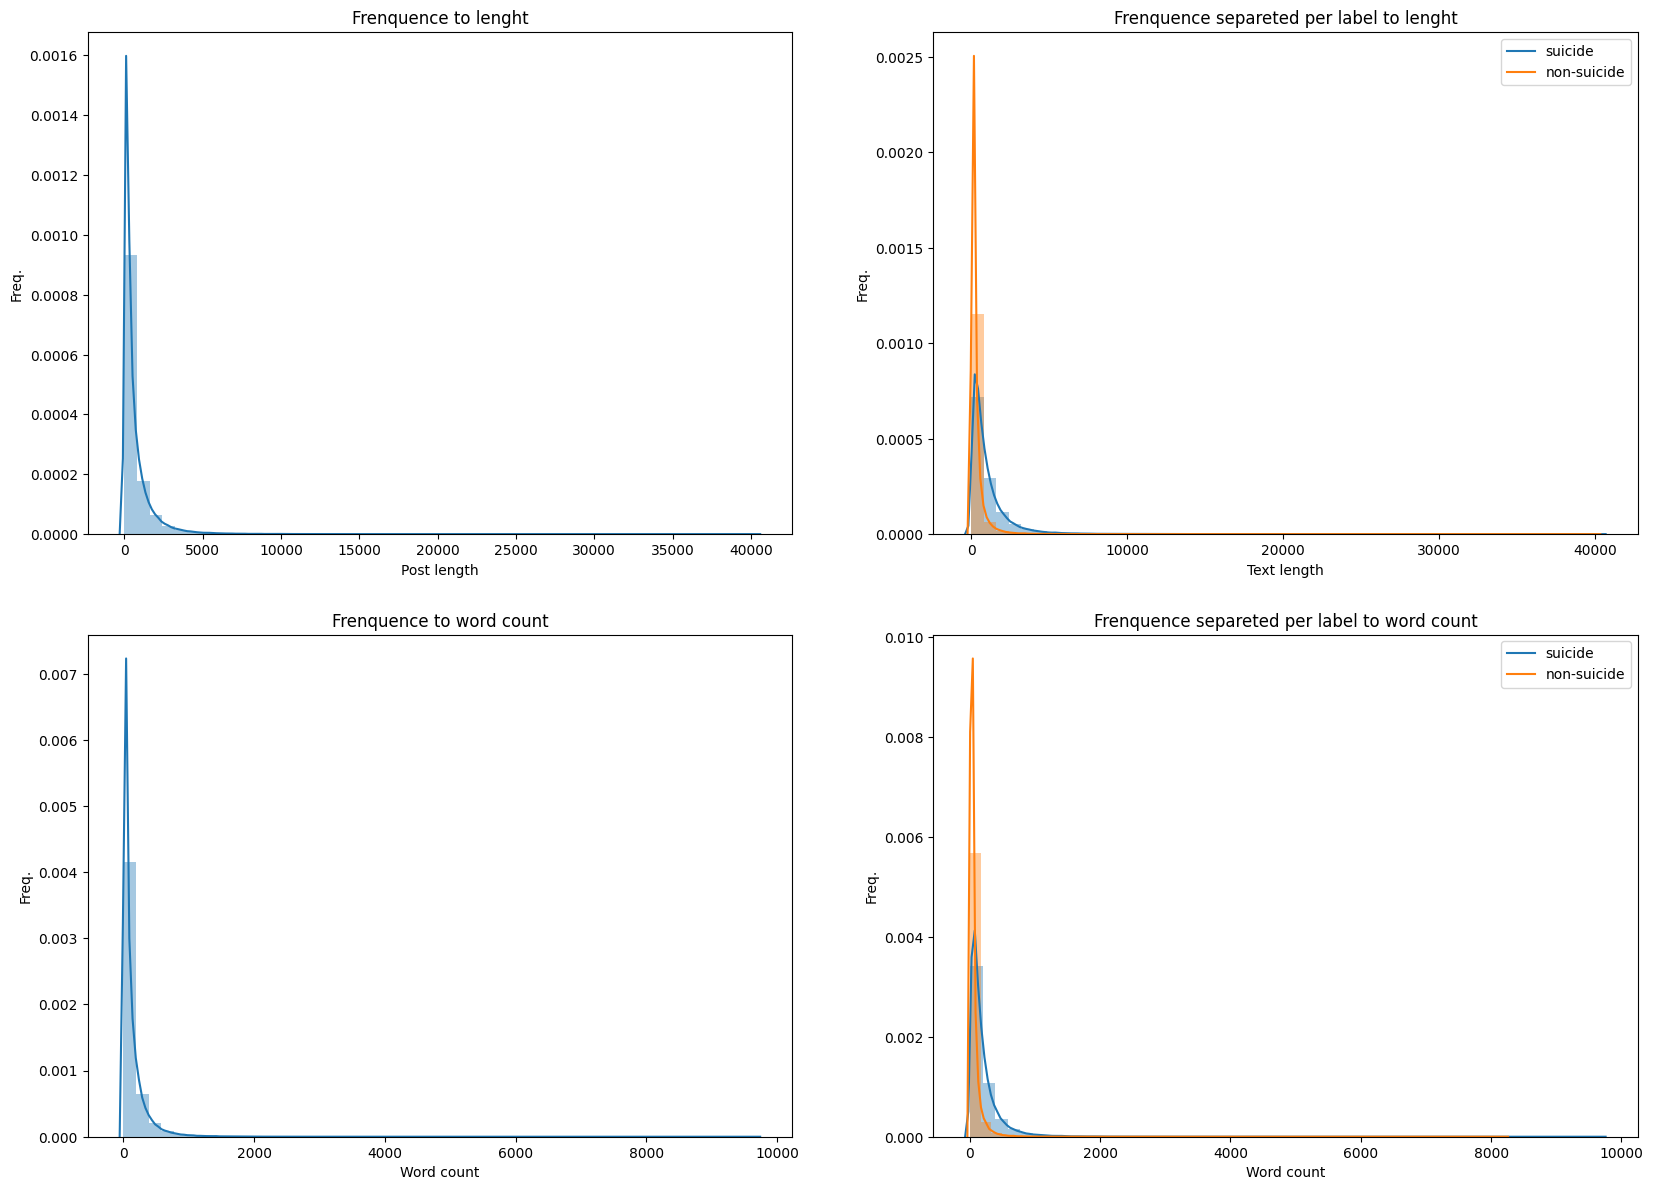

In [15]:
# show frenquence to lenght for each post
post_users_analyze['Post_len'] = post_users_analyze['text'].str.len()
plt.figure(figsize=(20,30))
plt.subplot(4, 2, 1)
ax = sns.distplot(post_users_analyze['Post_len'])
ax.set(xlabel='Post length', ylabel='Freq.')
plt.title('Frenquence to lenght')

# show frenquence separeted per label to lenght for each post
plt.subplot(4, 2, 2)
i = 0
while i < len(list_labels):
    ax = sns.distplot(post_users_analyze[post_users_analyze['class'] == list_labels[i]]['Post_len'])
    i = i + 1
ax.set(xlabel='Text length', ylabel='Freq.')
ax.legend(labels=list_labels)
plt.title('Frenquence separeted per label to lenght')

# show frenquence to word count for each post
post_users_analyze['word_count'] = post_users_analyze['text'].str.split().map(lambda x:len(x))
plt.subplot(4, 2, 3)
ax = sns.distplot(post_users_analyze['word_count'])
ax.set(xlabel='Word count', ylabel='Freq.')
plt.title('Frenquence to word count')

# show frenquence separeted per class to word count for each post
plt.subplot(4, 2, 4)
i = 0
while i < len(list_labels):
    ax = sns.distplot(post_users_analyze[post_users_analyze['class'] == list_labels[i]]['word_count'])
    i = i + 1
ax.set(xlabel='Word count', ylabel='Freq.')
ax.legend(labels=list_labels)
plt.title('Frenquence separeted per label to word count')
plt.show()

A very few posts have more than 5000 characters and more than 2000 words. Again most of the suicidal post's length are longer than non-suicidal post's. 

**Viewing the Word Cloud of Posts**

Word clouds are graphical representations of word frequency that give greater prominence to words that appear most frequently in a source text. The larger the word in the visual, the more common it is in the text(s). This type of visualization can help raters with exploratory textual analysis, identifying words that appear frequently in a set of interviews, documents, or text. It can also be used to communicate salient points or themes at the reporting stage.

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud,STOPWORDS

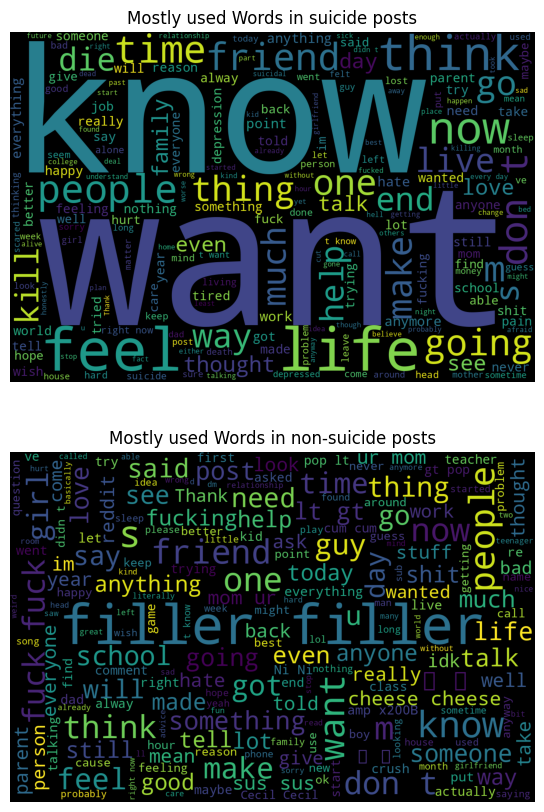

In [24]:
# words cloud of post 

# copy dataframe for analyze
post_users_analyze = df.copy()

# get list of labels
list_labels = post_users_analyze['class'].unique()

fig, axes = plt.subplots(2, 1, figsize=[20, 10])

i = 0
while i < len(list_labels):
    df_aux = df[df['class'] == list_labels[i]]['text']

    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='Black',
                          width=1200,
                          height=800
                          ).generate(" ".join(df_aux))

    axes[i].imshow(wordcloud)
    axes[i].axis('off')
    axes[i].set_title(f'Mostly used Words in {str(list_labels[i])} posts')
    i = i + 1

plt.show()   

Attribute Engineering

# Eliminating information that will not be used in the model training process

In [25]:

df.drop(columns = ["Unnamed: 0", "post_len", "word_count"], inplace=True)

In [26]:
labels = df['class'].values

In [27]:
df.isnull().any().any()

False

In [28]:
#Defining training, testing, and validation data gaps
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

In [29]:
# Diivision of data in training and testing
data_train, data_test = train_test_split(df,                                  
                                             test_size = 1 - train_ratio, 
                                             random_state = 43, stratify=labels)

In [30]:
 # The validation data will be represented by 15% of the initial dataset
data_validation, data_test = train_test_split(data_test, test_size=test_ratio/(test_ratio + validation_ratio),
                                                 random_state = 43)

In [31]:
data_test.head(5)

,text,class
117065,I would pay all my money to hire someone to ki...,suicide
43317,The cowards way outPeople talk about suicide l...,suicide
19684,If I have a kid and they come out as Croatian ...,non-suicide
120617,Which youtube channel do you believe produces ...,non-suicide
28821,Almost got hit by a fucking milk truck So i wa...,non-suicide


**Reading data with pre-processing using the NLTK library**

Now let's read the data, convert the text to lowercase, remove contractions and then convert it to tokens using the nltk library. We have two functions read_data to assemble the training data and read_test_data to assemble the test data.

In [32]:
import re

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                    "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                    "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                    "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                    "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                    "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
                    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                    "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
                    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
                    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
                    "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [37]:
def read_data(filename):
    """
    Extract posts from training data and perform pre-processing using nltk python library
    """
    data  = [[],[]] 
    train_data = {}
    for i in  tqdm(range(filename.shape[0])):
        text_string = filename[i, 0]
        text_string = text_string.lower()
        """ text cleaning"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string)
        """token"""
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Assign the class to the files
        """ Eliminate Sporwords """
        text_string  = [w for w in text_string if not w in stop_words]
        
        data[0].append(text_string)
        data[1].append(filename[i, 1])
        
        train_data[str(filename[i, 1])+'_'+str(i)] = text_string
    print('\tFinished reading training data') 
               
    return data, train_data

def read_test_data(filename):
    """
    Extract posts from test data and pre-process using nltk python library
    """
    test_data = {}
    for i in  tqdm(range(filename.shape[0])):
        text_string = filename[i, 0]
        text_string = text_string.lower()
        """ text cleaning"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string) 
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Assign the class to the files
        """ Assigns the relation to the document """
        test_data[str(filename[i, 1])+'_'+str(i)] = text_string
    print('\tCompleted reading test data') 
               
    return test_data

print('Processing train data...\n')
words, train_words = read_data(np.array(data_train))

print('\nProcessing test data...\n')

test_words = read_test_data(np.array(data_test))

Processing train data...



100%|██████████| 162451/162451 [01:11<00:00, 2286.28it/s]


	Finished reading training data

Processing test data...



100%|██████████| 34812/34812 [00:14<00:00, 2359.55it/s]

	Completed reading test data


**Building the Dictionaries**

To understand each of these elements, let's also assume the text "I like to go to school"

dictionary: maps a word to an ID (i.e. {I:0, like:1, to:2, go:3, to:4, school:5})
reverse_dictionary: maps an ID to a word (i.e. {0:I, 1:like, 2:to, 3:go, 4:to, 5:school}
count: List of elements (word, frequency) (i.e. [(I,1),(like,1),(to,2),(go,1),(to,1),(school,1)]
data : Contains the text string we read, where words are replaced by word IDs (i.e. [0, 1, 2, 3, 4, 5])
We've also introduced an additional special token called UNK to indicate that rare words are too rare to use.

In [38]:
vocabulary_size = 5500
Words  = []
def build_dataset(words):
    for word in words[0]:
        Words.extend(word)  
    count = [['UNK', -1]]
    count.extend(collections.Counter(Words).most_common(vocabulary_size - 1))
    # Dictionary of sentences
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in Words:
        if  word in dictionary:            
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']            
            unk_count = unk_count + 1
            
        data.append(word)

    count[0][1] = unk_count
    assert len(dictionary) == vocabulary_size

    return data, count, dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    '''
    Here we use this function to convert word strings into IDs with a given dictionary
    '''
    data = list()
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
        data.append(word)
    return data

# Processing training data
data, count, dictionary = build_dataset(words)

train_data = {}

print('Building the training dataset for the document\n')
for k,v in tqdm(train_words.items()):
    train_data[k] = build_dataset_with_existing_dictionary(train_words[k],dictionary)

#processing test data

test_data = {}

print('Building the test dataset for the document\n')
for k,v in tqdm(test_words.items()):
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)
    
print('\nMost common words (+UNK)', count[:5])
print('\ndata sample', data[:10])
#print('\nChaves: ', test_data.keys())
#print('\nItems: ', test_data.items())

#We removed it to free up memory on the computer as we no longer need these objects. I'll just keep the dictionary
del words  
del data
del count
#del dictionary

Building the training dataset for the document



100%|██████████| 162451/162451 [00:04<00:00, 39535.79it/s]


Building the test dataset for the document



100%|██████████| 34812/34812 [00:01<00:00, 31720.52it/s]


Most common words (+UNK) [['UNK', 732695], ('like', 127154), ('want', 104530), ('know', 92177), ('feel', 85942)]

data sample ['moved', 'husbands', 'job', 'left', 'everything', 'behind', 'slowly', 'slipping', 'away', 'moved']


**doc2Vec Training and Evaluation Models**
Doc2vec is an unsupervised algorithm for generating vectors for sentences, paragraphs, or documents (Distributed representations of sentences and document). This is a concept that was presented in 2014 by Le & Mikilov, see this article. This algorithm is an adaptation of word2vec, and the vectors generated by doc2vec can be used for tasks such as finding similarities between sentences, paragraphs, or documents.

A document vector is an abstract variable-length representation of the contextual meaning of a given document type. Just like a word vector, it is the product of the training process for a neural network, where the input is typically a one-hot encoded term encoded from the vocabulary of the model and the output is a probability distribution for words in the next context window.

We first instantiate a doc2vec - Distributed Bag of Words (DBOW) model. In the word2vec architecture, we have the algorithms "continuous bag of words" (CBOW) and "skip-gram" (SG), while in the doc2vec architecture, the corresponding algorithms are "distributed memory" (DM) and "distributed bag of words" (DBOW)

DBOW is the doc2vec model analogous to the Skip-gram model of word2vec. Paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph, given a randomly sampled word from the paragraph.




**here Can have the doc vec pic**

**Preparation of data for vocabulary creation in doc2vec**

In [39]:
# Converts from Dictionary to List
data_train = [ [k,v] for k, v in train_data.items() ]
data_train = np.array(data_train)
data_test = [ [k,v] for k, v in test_data.items() ]
data_test = np.array(data_test)

In [40]:
# function to Identify the classes of the documents and prepare the data for the algorithm
def prepare_data(data):
    datax = [[],[]]
    for x in range(data.shape[0]):
        s = data[x][0]
        s = s.split("_")
        datax[0].append(s[0])
        datax[1].append(data[x][1])                
    return datax

data_train = prepare_data(data_train)
data_test = prepare_data(data_test)

In [41]:
def label_sentences(corpus, topics):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    I did this using the TaggedDocument method, tagging with the document's own class.
    """
   
    labeled = []
    tags = np.unique(topics, return_counts=False)
    for i, v in enumerate(corpus):
        label = [s for s in tags if topics[i] in s and len(s) == len(topics[i])]
        doc =  " ".join(str(x) for x in v)
        labeled.append(TaggedDocument(doc.split(), label))
    return labeled
X_train = label_sentences(data_train[1], data_train[0])
X_test  = label_sentences(data_test[1], data_test[0])

In [42]:
X_test[1]


TaggedDocument(words=['the', 'cowards', 'way', 'outpeople', 'talk', 'about', 'suicide', 'like', 'it', 's', 'the', 'cowards', 'way', 'out', 'but', 'i', 'challenge', 'you', 'to', 'stare', 'into', 'the', 'abyss', 'with', 'no', 'clue', 'what', 's', 'down', 'there', 'and', 'no', 'way', 'back', 'out', 'that', 's', 'no', 'cowards', 'way', 'out', 'in', 'my', 'book'], tags=['suicide'])

In [43]:
len(X_train)

162451

In [44]:
len(X_test)

34812

In [45]:

# Instantiating a Doc2Vec template with a 128-word vector

model_dbow = Doc2Vec(dm=0, vector_size=128, window=10, negative=5, cbow_mean=1, min_count=1, alpha=0.1, min_alpha=0.005)
model_dbow.build_vocab([x for x in tqdm(X_train)])


# Alindo 50 iterations on the training corpus.

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(X_train)]), total_examples=len(X_train), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 162451/162451 [00:00<00:00, 3455234.96it/s]


**Building the resource vectors for the classifier**

In [46]:
%%time

# Training data

train_targets, train_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=100)) for doc in tqdm(X_train)])

100%|██████████| 162451/162451 [30:13<00:00, 89.58it/s] 

CPU times: user 29min 35s, sys: 6.36 s, total: 29min 41s
Wall time: 30min 13s


In [47]:
%%time

# testing data

test_targets, test_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=100)) for doc in tqdm(X_test)])

100%|██████████| 34812/34812 [07:30<00:00, 77.28it/s]


CPU times: user 7min 23s, sys: 1.59 s, total: 7min 24s
Wall time: 7min 30s


In [48]:
X_test[45]

TaggedDocument(words=['i', 'want', 'to', 'be', 'betterrecently', 'life', 's', 'gotten', 'alot', 'worse', 'my', 'bipolar', 'flared', 'up', 'my', 'suicidal', 'thoughts', 'are', 'much', 'more', 'active', 'than', 'before', 'and', 'life', 'once', 'again', 'feels', 'like', 'suffering', 'every', 'moment', 'trying', 'to', 'survive', 'i', 'want', 'to', 'get', 'better', 'but', 'i', 'do', 'not', 'know', 'how', 'i', 'am', 'with', 'counselors', 'taking', 'antidepressants', 'and', 'mood', 'stabilizers', 'and', 'i', 'feel', 'like', 'it', 'is', 'my', 'fault', 'i', 'am', 'not', 'getting', 'better', 'everytime', 'someone', 'mentions', 'mental', 'health', 'abuse', 'or', 'anything', 'like', 'that', 'i', 'get', 'defensive', 'and', 'have', 'intrusive', 'thoughts', 'i', 'want', 'to', 'be', 'better', 'but', 'i', 'do', 'not', 'know', 'how', 'i', 'want', 'a', 'cry', 'for', 'help', 'in', 'a', 'suicide', 'attempt', 'not', 'to', 'actually', 'succeed', 'then', 'i', 'feel', 'like', 'i', 'am', 'just', 'attention', 's

**Training the Logistic Regression Classifier.**

In [49]:
# Applying Logistic Regression
topics = ['suicide','non-suicide']
logreg = LogisticRegression(n_jobs=1, C=0.1, solver = 'lbfgs', penalty = 'l2', max_iter=10000)
logreg.fit(train_regressors, train_targets)
y_pred = logreg.predict(test_regressors)
y_score = logreg.predict_proba(test_regressors)

In [50]:
print('accuracy %s' % accuracy_score(y_pred, test_targets))
print(classification_report(test_targets, y_pred,target_names=topics))

accuracy 0.9227277950132138
              precision    recall  f1-score   support

     suicide       0.93      0.91      0.92     17302
 non-suicide       0.91      0.94      0.92     17510

    accuracy                           0.92     34812
   macro avg       0.92      0.92      0.92     34812
weighted avg       0.92      0.92      0.92     34812



In [51]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(topics))
    target_names = topics
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=topics)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    return cm

accuracy 0.9227277950132138
confusion matrix
 [[16377  1133]
 [ 1557 15745]]
(row=expected, col=predicted)


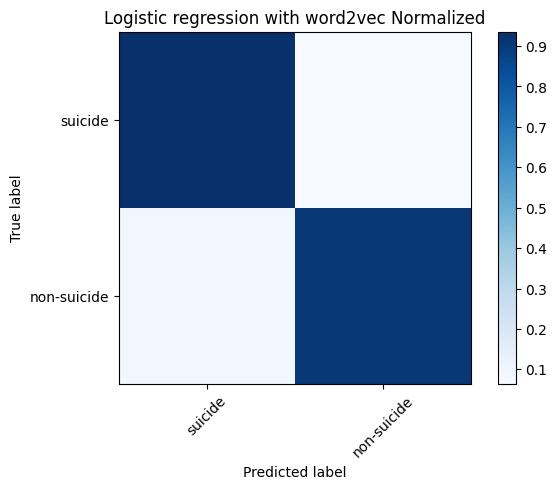

In [53]:
cm = evaluate_prediction(y_pred, np.array(test_targets), "Logistic regression with word2vec")

In [64]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install scikit-plot

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

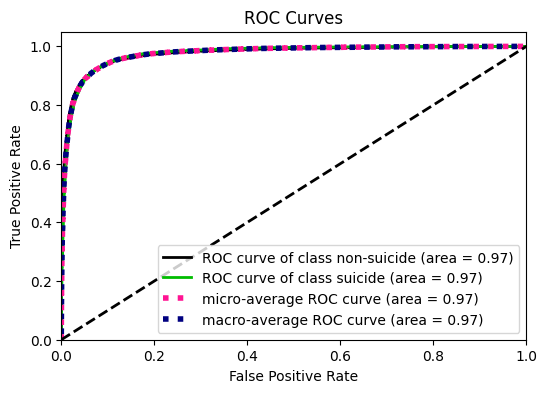

In [65]:
import scikitplot as skplt
skplt.metrics.plot_roc(test_targets, y_score, figsize=(6, 4))

On a Receiver Operating Characteristic (ROC) curve, the true positive rate (Sensitivity) is plotted as a function of the false positive rate (100-specificity) for different cutoff points. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a given decision limit. 

A test with perfect discrimination (no overlap in the two distributions) has an ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore, the closer the ROC curve is to the upper left, the greater the overall accuracy of the test (Zweig & Campbell, 1993).

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

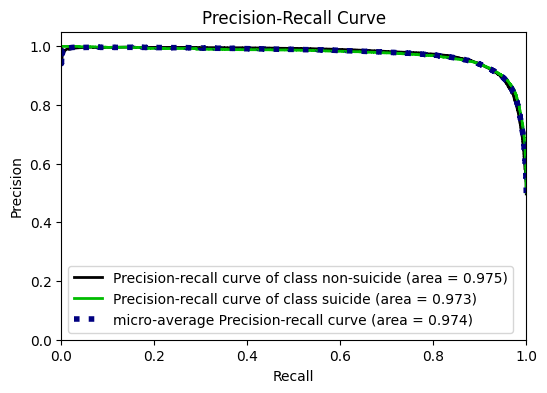

In [66]:
skplt.metrics.plot_precision_recall(test_targets, y_score, figsize=(6, 4))

The precision-recall curve shows the trade-off between accuracy and recovery for different limits. A high area under the curve represents high recovery and high accuracy, where high accuracy relates to a low false positive rate and high recovery relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision) as well as returning most of all positive results (high recovery).


The ROC Curve and Precision-Recall charts demonstrate a great ability of the model to label all instances correctly.

**Preparation of validation data for algorithm application**

In [67]:
# Division of data into X and Y

X_validation = data_validation.loc[:, data_validation.columns != 'class']
Y_validation = data_validation['class']

In [68]:
def read_valid_data(filename):
    """
    Extracts posts from validation data and performs preprocessing using the nltk python library
    """
    valid_data = {}
    for i in tqdm(range(filename.shape[0])):
        text_string = filename[i, 0]
        text_string = text_string.lower()
        """ Text cleanup"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string) 
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Assigns the class to the files
        """ Assigns the relationship to the document """
        valid_data[str(i)] = text_string
    print('\tValidation data reading completed\n') 
               
    return valid_data

In [69]:
valid_words = read_valid_data(np.array(data_validation))

100%|██████████| 34811/34811 [00:14<00:00, 2412.20it/s]

	Validation data reading completed



In [70]:
# Processing validation data

valid_data = {}
    
print('Building the validation dataset for the post\n')
for k,v in tqdm(valid_words.items()):
    valid_data[k] = build_dataset_with_existing_dictionary(valid_words[k],dictionary)

Building the validation dataset for the post



100%|██████████| 34811/34811 [00:03<00:00, 10614.72it/s]


In [71]:
# Converts from Dictionary to List
data_valid = [ [k,v] for k, v in valid_data.items() ]
data_valid = np.array(data_valid)

In [72]:
data_valid = prepare_data(data_valid)

In [73]:
X_valid = label_sentences(data_valid[1], data_valid[0])

**Building the resource vectors for the classifier**

In [74]:
%%time

# data Validation

valid_targets, valid_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=100)) for doc in tqdm(X_valid)])

100%|██████████| 34811/34811 [07:44<00:00, 75.00it/s]

CPU times: user 7min 34s, sys: 1.64 s, total: 7min 36s
Wall time: 7min 44s


In [75]:
# Deleting the dictionary
del dictionary

In [76]:
y_pred = logreg.predict(valid_regressors)
y_score = logreg.predict_proba(valid_regressors)

In [77]:
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred,target_names=topics))

accuracy 0.9246502542299848
              precision    recall  f1-score   support

     suicide       0.93      0.92      0.92     17510
 non-suicide       0.92      0.93      0.92     17301

    accuracy                           0.92     34811
   macro avg       0.92      0.92      0.92     34811
weighted avg       0.92      0.92      0.92     34811



accuracy 0.9246502542299848
confusion matrix
 [[16162  1139]
 [ 1484 16026]]
(row=expected, col=predicted)


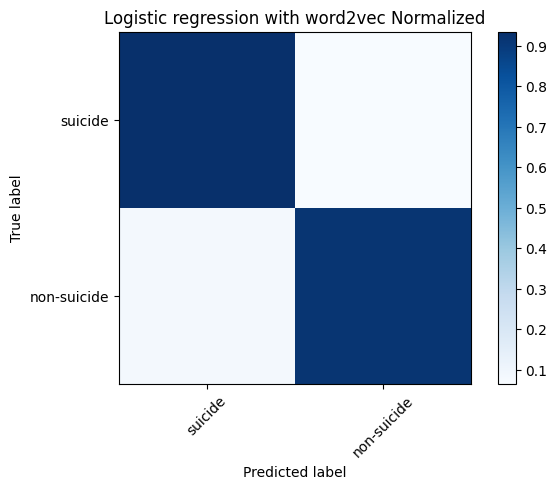

In [78]:
cm = evaluate_prediction(y_pred, np.array(Y_validation), "Logistic regression with word2vec")

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

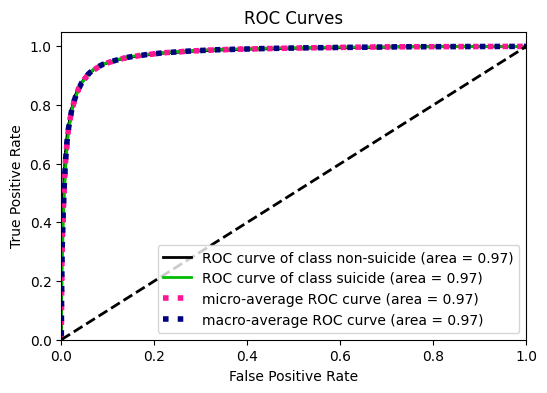

In [79]:
skplt.metrics.plot_roc(Y_validation, y_score, figsize=(6, 4))

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

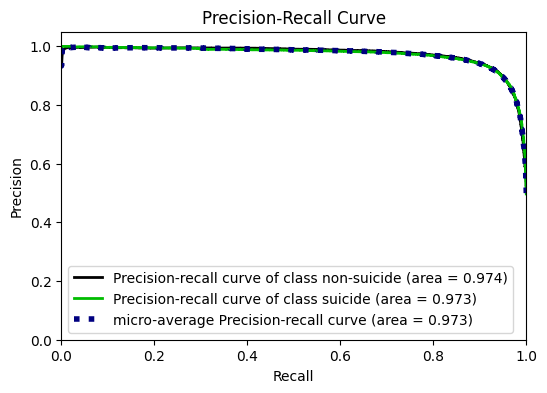

In [80]:
skplt.metrics.plot_precision_recall(Y_validation, y_score, figsize=(6, 4))

The ROC Curve and Precision-Recall charts demonstrate a great ability of the model to label all instances correctly.

**Cohen Kappa**

The Cohen kappa is a metric often used to assess agreement between two evaluators. It can also be used to evaluate the performance of a rating model, like many other evaluation metrics, the Cohen kappa is calculated based on the confusion matrix.

Landis and Koch (1977) classify the different levels of agreement (or reproducibility), the Kappa ranges from 0 to 1, as shown in the table below:


  Kappa values           Interpretation

       < 0            Lack of agreement

     0 - 0.20         Minimum agreement

  0.21 - 0.40            Reasonable agreement

  0.41 - 0.60            Moderate agreement 

  0.61 - 0.80            Substantial agreement

  0.81 - 1.00            Near-perfect agreement



  Kappa statistics are often used as a measure of reliability between two human evaluators. In supervised machine learning, one "evaluator" reflects the basic truth, that is, the actual values of each instance to be classified, obtained from labeled data, and the other "evaluator" is the machine learning classifier used to perform the classification.

In [81]:
# Applying Kappa Statistics
cohen_kappa = cohen_kappa_score(Y_validation, y_pred)

In [82]:
cohen_kappa

0.8493130091539671

**Conclusion**
Our model obtained a Kappa score of 0.85, according to the table, this means that there is an almost perfect agreement between the classification performed by the model and the classification related to the posts of the subreddits of the Reddit platform, demonstrating that the model has achieved an excellent ability to correctly classify posts with comments from people with potential suicidal tendencies.

**Referances**

[Distributed Representations of Sentences and Document](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)

[Gemsin](https://radimrehurek.com/gensim/models/keyedvectors.html)

[Gensim Doc2Vec Tutorial on the IMDB Sentiment Dataset](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb)


[Document classification with word embeddings tutorial](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb)

[Distributed Representations of Words and Phrases and their Compositionality](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)

[Extracting Information from Text](https://www.nltk.org/book/ch07.html)

[A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)


Using Deep Learning for End to End Multiclass Text Classification

